# CPPI와 낙폭 제한

이번 시간에는 기본적인 CPPI 전략을 구현하고 이를 다양한 포트폴리오에 테스트해보겠습니다.

먼저 평소처럼 `port_opt_toolkit.py` 모듈을 로드하여 시작합니다.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import port_opt_toolkit as potk

# Load the industry returns and the total market index we previously created
ind_return = potk.get_ind_returns()
tmi_return = potk.get_total_market_index_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


CPPI 알고리즘은 매우 간단하게 구현할 수 있습니다. 이 알고리즘의 입력변수에는 위험 자산과 무위험 자산의 수익률, 초기 자산의 크기, 그리고 자본의 하한선이 포함됩니다.

In [4]:
import pandas as pd
import numpy as np

risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

이제 처음부터 매 시점을 거치면서 이 전략을 백테스트해야 합니다.

1. 쿠션(자산 가치 - 하한) 계산
2. 승수에 기반한 투자 비중 계산
3. 새로운 자산 가치 계산

시계열 작업에서는 for 문을 사용하는 대신, 판다스와 넘파이를 사용하여 내부적이고 또 효율적인 방식으로 루프를 수행하는 것이 더 쉽습니다.

하나씩 구현을 해보도록 하겠습니다.

In [12]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [14]:
for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()

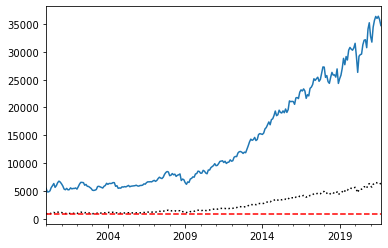

In [15]:
ind = "Beer"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

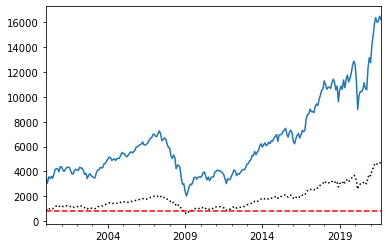

In [16]:
ind = "Fin"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

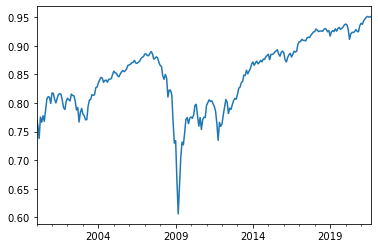

In [17]:
cushion_history["Fin"].plot()

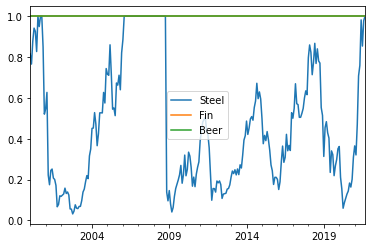

In [18]:
risky_w_history.plot()

이 모든 것을 종합하여 하나의 함수로 만든 뒤 `port_opt_toolkit.py`에 추가합니다.

```python
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor

    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    
    for step in range(n_steps):
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r
    }
    return backtest_result

```

또한 수익률에 대한 통계치 요약을 제공하는 함수 또한 작성해 보겠습니다.

```python

def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

```

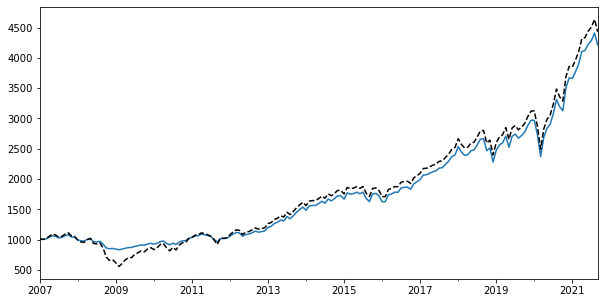

In [20]:
btr = potk.run_cppi(tmi_return["2007":])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

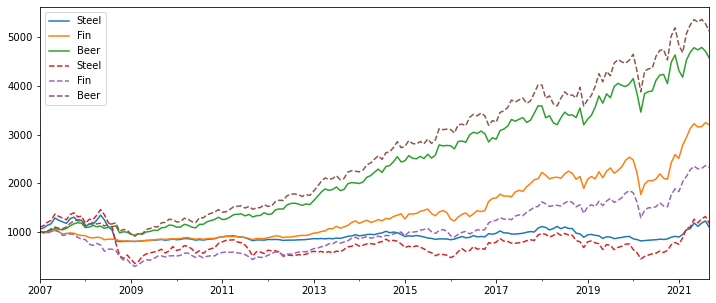

In [21]:
btr = potk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [22]:
potk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.002249,0.132146,-1.082229,9.450674,0.067546,0.099658,-0.204550,-0.404132
Fin,0.082147,0.142313,-0.421750,7.825173,0.060719,0.091600,0.356461,-0.301886
Beer,0.108322,0.125875,-0.452473,4.201926,0.053974,0.078928,0.605470,-0.217280


In [23]:
potk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.004812,0.320382,-0.348530,4.144941,0.153691,0.209289,-0.076934,-0.758017
Fin,0.058960,0.217669,-0.686337,4.656130,0.105829,0.156133,0.129198,-0.720323
Beer,0.116520,0.136054,-0.466360,4.193366,0.058509,0.084844,0.618800,-0.271368


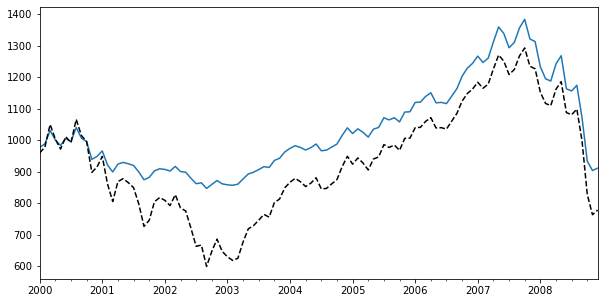

In [24]:
btr = potk.run_cppi(tmi_return["2000":"2008"])
ax = btr["Wealth"].plot(legend=False, figsize=(10, 5))
btr["Risky Wealth"].plot(ax = ax, style="k--", legend=False)

보험 전략은 일반적으로 손실을 줄이는 데 도움이 되지만 우리는 명시적으로 손실을 제한하도록 조정할 수도 있습니다.

## 명시적 낙폭 제한

새로운 매개변수 `drawdown`이 주어지면 바닥을 조정하도록 코드를 수정합니다.

```python
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
```

이제 `drawdown`을 매개변수로 가지는 `run_cppi` 함수를 호출할 수 있습니다.

예를 들어, CPPI를 실행하고 낙폭을 25%로 제한하려면 아래의 코드를 실행하면 됩니다.

You can now call `run_cppi` witk a parameter `drawdown`. For instance, to run CPPI and limit the drawdown to 25%

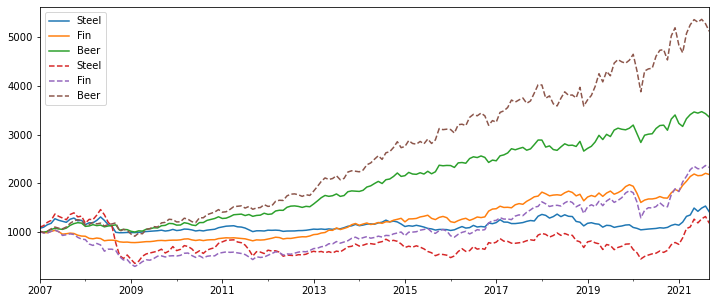

In [25]:
btr = potk.run_cppi(ind_return["2007":][["Steel", "Fin", "Beer"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [26]:
potk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.018811,0.105010,-0.103833,-0.248059
Fin,0.054251,0.094818,0.248809,-0.243710
Beer,0.085123,0.091034,0.589254,-0.161186


In [27]:
potk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Steel,0.004812,0.320382,-0.076934,-0.758017
Fin,0.058960,0.217669,0.129198,-0.720323
Beer,0.116520,0.136054,0.618800,-0.271368


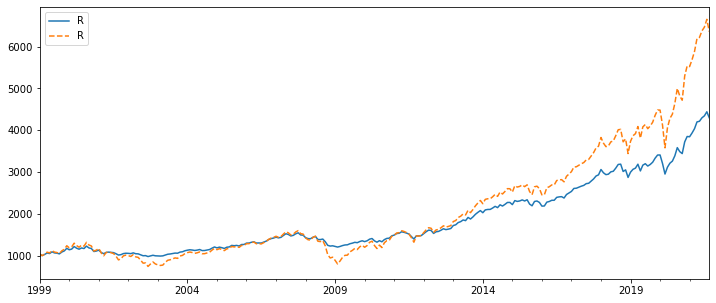

In [28]:
btr = potk.run_cppi(tmi_return["1999":], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [29]:
potk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.065145,0.084938,0.402616,-0.220733


In [30]:
potk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
R,0.083337,0.153891,0.337138,-0.499547
